In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pydot
import datetime
import geopandas as gpd
import seaborn as sns
import warnings

In [2]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data = gpd.read_file('Data_final.geojson')
#data = gpd.read_file('Data_full_mandals.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [3]:
warnings.filterwarnings('ignore')

In [4]:
data['ModifiedDateTime'] =  pd.to_datetime(data['ModifiedDateTime'])

In [5]:
data.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'Year', 'Crops', 'Trees',
       'Built Area', 'ModifiedDateTime', 'NO2', 'PM2.5', 'Season', 'Paddy',
       'Maize', 'Soybean', 'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged',
       'ST_lagged', 'BA_lagged', 'geometry'],
      dtype='object')

# NO2 & PM2.5

In [11]:
data['Month'] = data['ModifiedDateTime'].dt.month

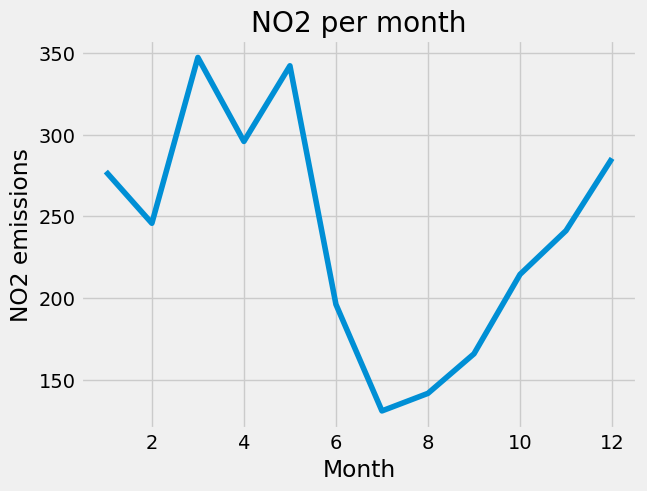

In [15]:
avg = data.groupby(['Month'])['NO2'].mean().reset_index()

plt.plot(avg['Month'], avg['NO2'])
plt.xlabel('Month')
plt.ylabel('NO2 emissions')
plt.title('NO2 per month')
plt.show()

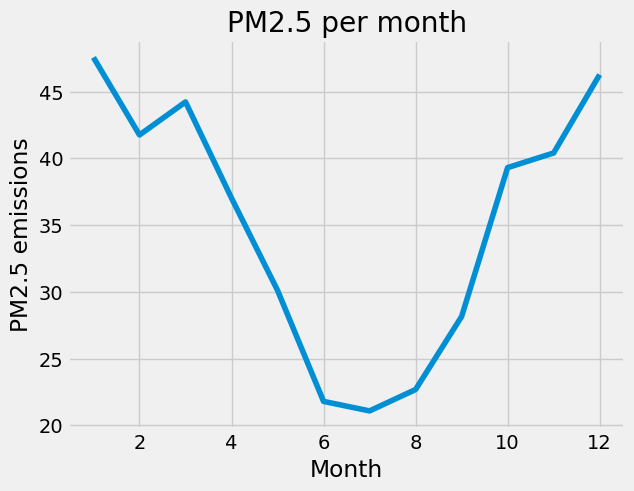

In [17]:
avg = data.groupby(['Month'])['PM2.5'].mean().reset_index()

plt.plot(avg['Month'], avg['PM2.5'])
plt.xlabel('Month')
plt.ylabel('PM2.5 emissions')
plt.title('PM2.5 per month')
plt.show()

Crop Distribution

In [54]:
#Interesting Crops
crops = ['Paddy', 'Maize', 'Soybean', 'Cotton', 'Chillies', 'Turmeric']

#Get the Crop Area's per Season
season_data = data.groupby(['Dist_Name', 'Mandal_Nam', 'Season', 'Year'])[crops].mean().reset_index()
crops_data = season_data[season_data['Season']!='None']

#Count the Amount of squared km and sort the list
amounts = [crops_data['Paddy'].sum(), crops_data['Maize'].sum(), crops_data['Soybean'].sum(), crops_data['Cotton'].sum(), crops_data['Chillies'].sum(), crops_data['Turmeric'].sum()]
amounts.sort(reverse=True)

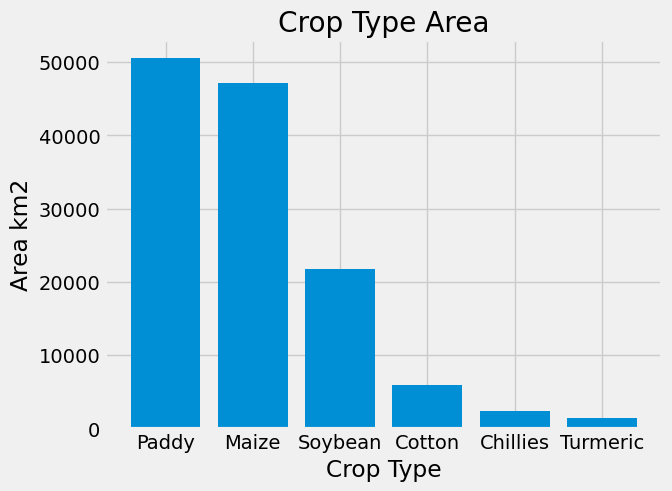

In [55]:
plt.bar(crops, amounts)
plt.title('Crop Type Area')
plt.xlabel('Crop Type')
plt.ylabel('Area km2')
plt.show()


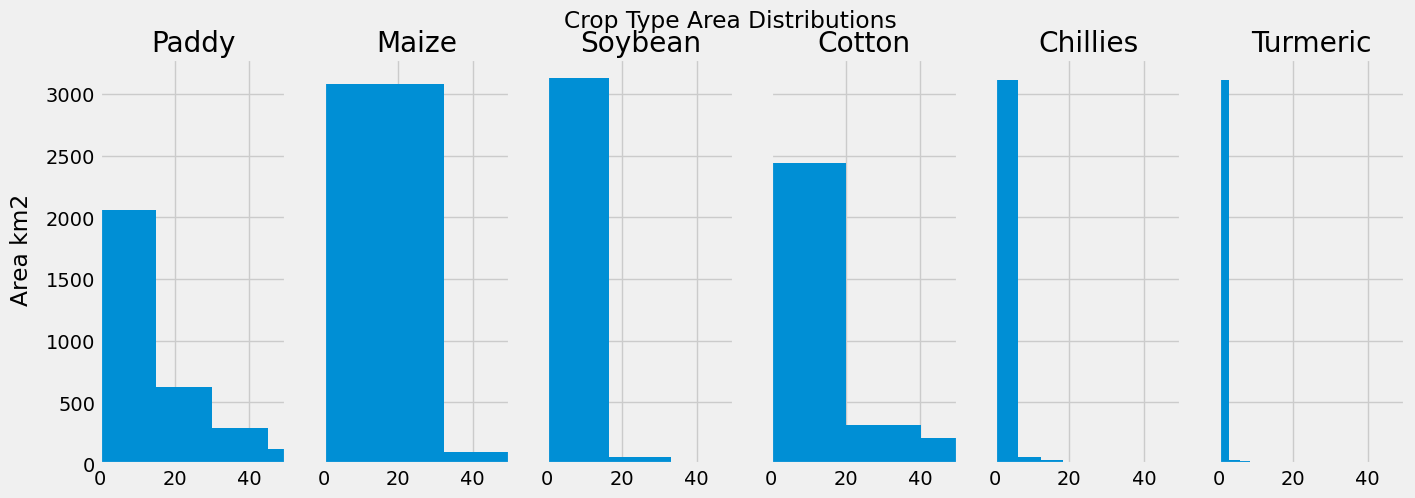

In [56]:
fig, axs = plt.subplots(1, 6, sharey=True, sharex=True, figsize=(15, 5))
fig.suptitle('Crop Type Area Distributions')
for crop in range(0, len(crops)):
    axs[crop].hist(crops_data[crops[crop]])
    axs[crop].set_title(crops[crop])
    axs[crop].set_xlim([0, 50])

fig.supylabel('Area km2')
plt.show()

Correlations

In [57]:
#We also want to include Amount of Fires and FRP
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = gpd.read_file('fires_data_classified.geojson')
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = fire_data.geometry, crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data = geo_fire_data[['geometry', 'acq_date', 'fireID', 'frp']]
geo_fire_data['geometry'] = geo_fire_data['geometry'].to_crs(epsg = 4326)
boundaries = gpd.GeoDataFrame(mandal_boundaries, geometry = mandal_boundaries.geometry, crs = {'init': 'epsg:4326'}) 

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Selects the years we are interested in, depending on the input of the function
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2016-01-01') & (geo_fire_data['acq_date'] < '2019-01-01')]

#Count all fires within a region given by the boundaries dataframe
fires_per_boundaries= gpd.sjoin(geo_fire_data, boundaries, how="inner")

#Create the right time format: We count per month
fires_per_boundaries['day'] = 1 
fires_per_boundaries['year'] = pd.Series(pd.to_numeric(fires_per_boundaries['year'], errors='coerce'), dtype='int64')
fires_per_boundaries['month'] = pd.Series(pd.to_numeric(fires_per_boundaries['month'], errors='coerce'), dtype='int64')
fires_per_boundaries['ModifiedDateTime'] = pd.to_datetime(fires_per_boundaries[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

unit_number = 'Number of Fires'

#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_boundaries_count = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_boundaries_count[unit_number] = fires_per_boundaries_count[0] 
del fires_per_boundaries_count[0] 

unit_frp = 'Fire Radiative Power (MW)'
fires_per_boundaries_count_2 = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_per_boundaries_count[unit_frp] = fires_per_boundaries_count_2[0] 

fires_per_boundaries_count['ModifiedDateTime'] =  pd.to_datetime(fires_per_boundaries_count['ModifiedDateTime'])

In [58]:
#Create the dataframe of interest with fires added
data_all = pd.merge(fires_per_boundaries_count, data, on=['index', 'ModifiedDateTime'], how='right')
data_all = data_all.rename(columns = {'Number of Fires': 'Fires', 'Fire Radiative Power (MW)': 'FRP'}) 
data_parameters = ['Fires', 'FRP', 'NO2', 'PM2.5', 'Paddy', 'Maize', 'Soybean', 'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_lagged', 'BA_lagged', 'Crops', 'Trees', 'Built Area']
data_corr = data_all[data_parameters]

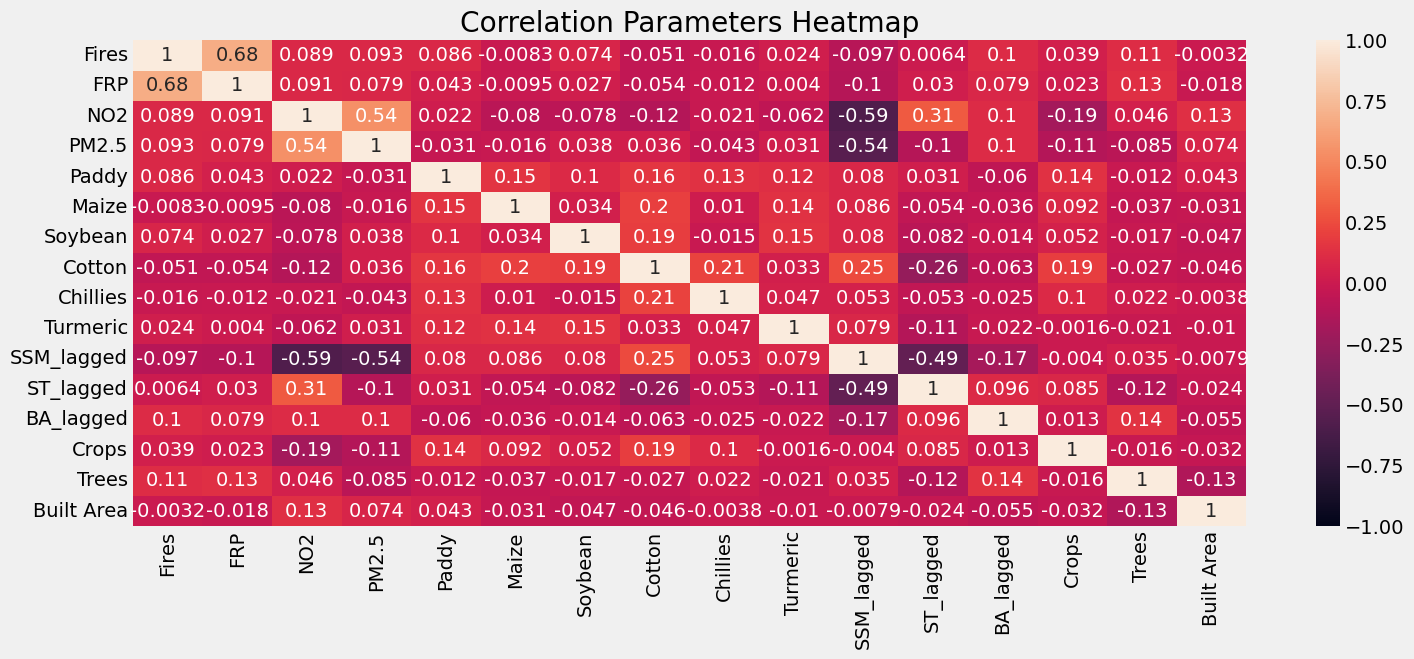

In [59]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Parameters Heatmap')
plt.show()

Parameters of interest

In [64]:
parameters = ['Fires', 'FRP', 'NO2', 'PM2.5', 'SSM_lagged', 'ST_lagged', 'BA_lagged', 'Crops', 'Trees', 'Built Area']
units = ['(Number of Fires)', '(MW)', '(billion molecules per mm2)', '(ug per m3)', '(mm)', '(Degrees Celsius)', '(Area km2)', '(Area km2)', '(Area km2)', '(Area km2)']
distributions_data = data_corr[parameters]

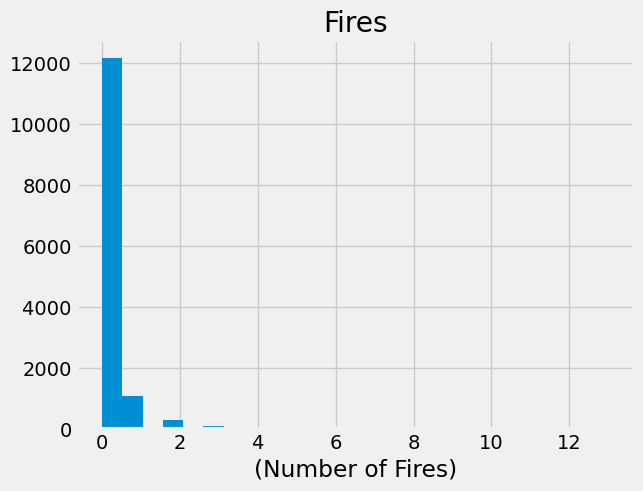

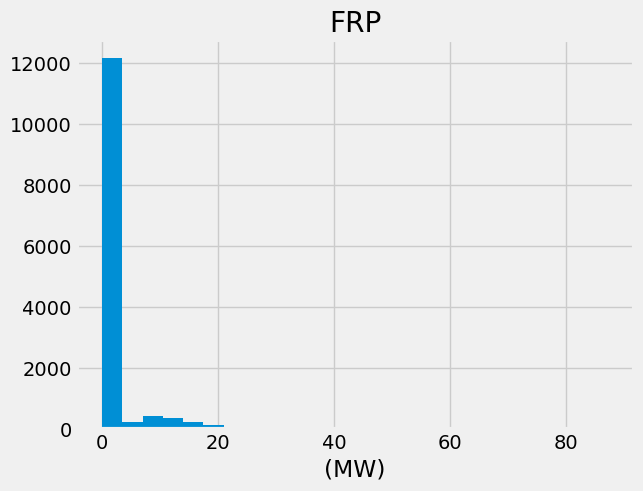

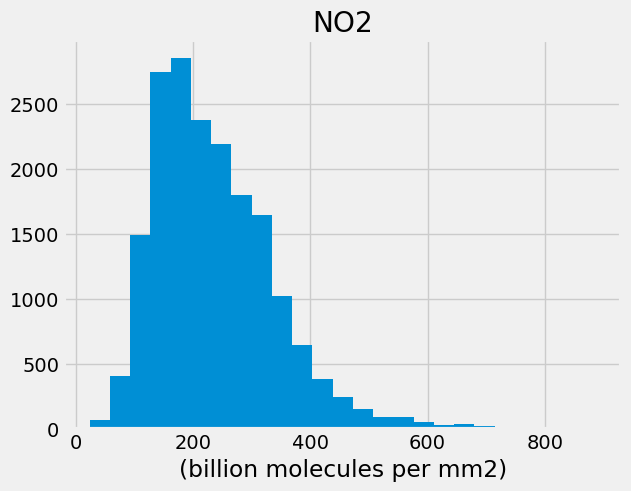

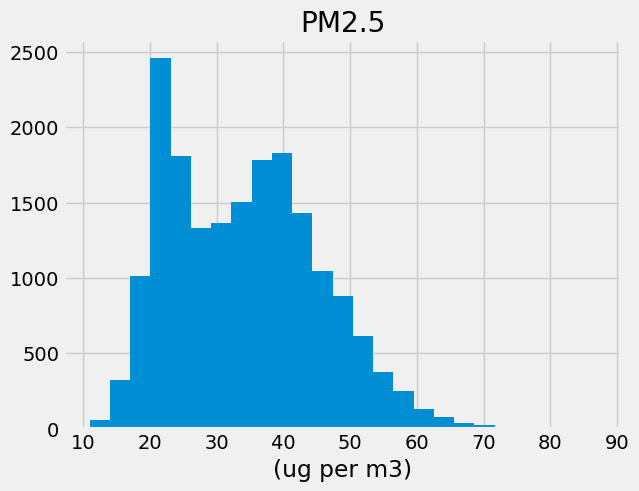

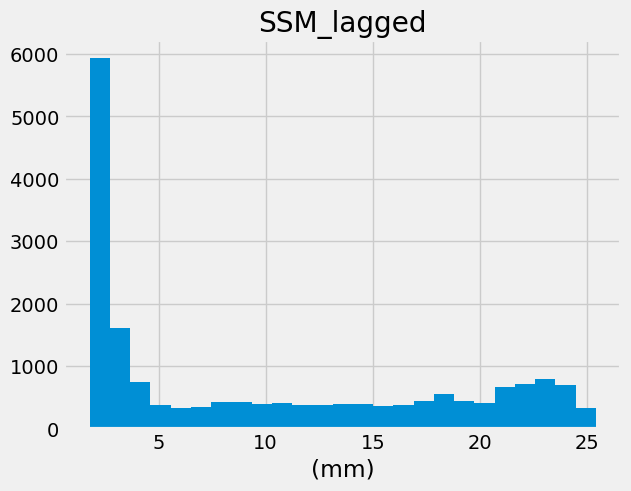

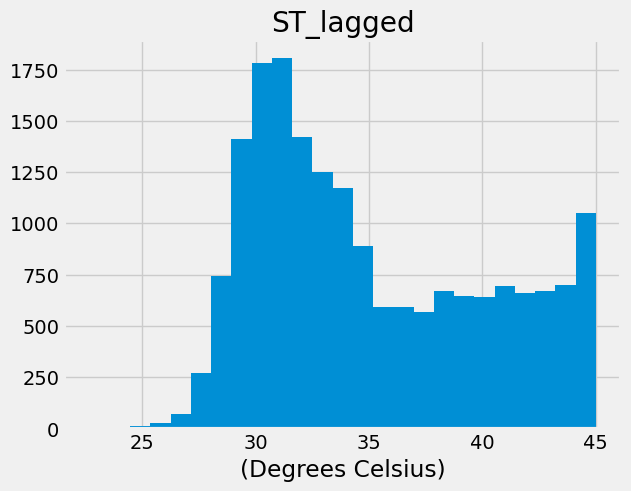

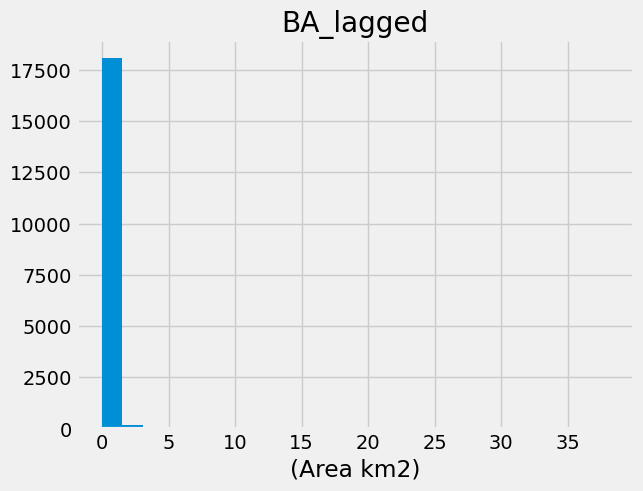

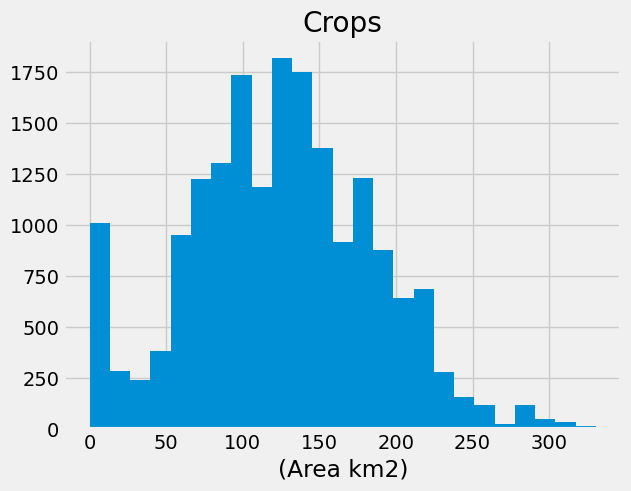

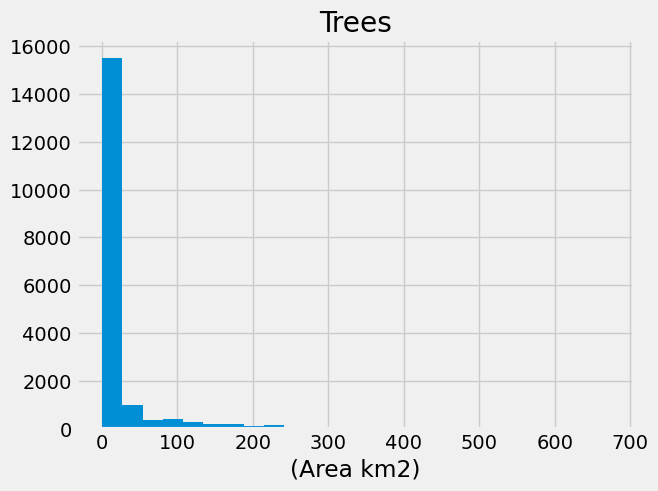

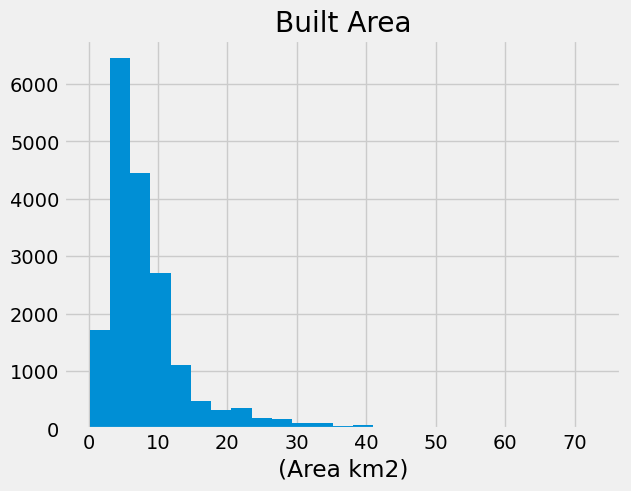

In [66]:
for dat in range(0, len(parameters)):
    plt.hist(distributions_data[parameters[dat]], bins=25)
    plt.title(parameters[dat])
    plt.xlabel(units[dat])

    plt.show()

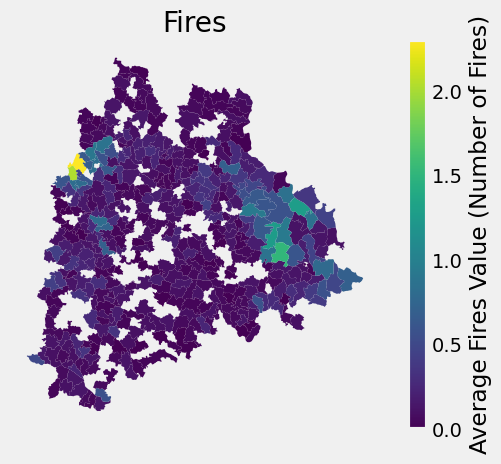

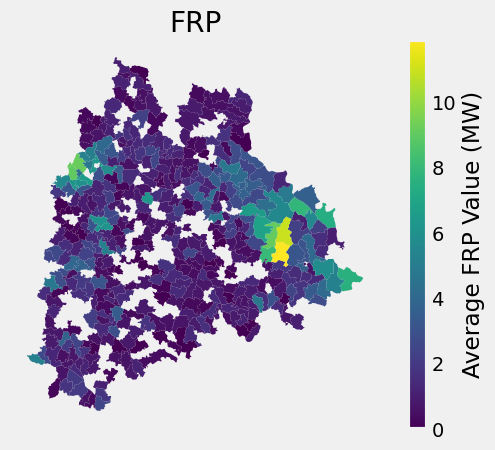

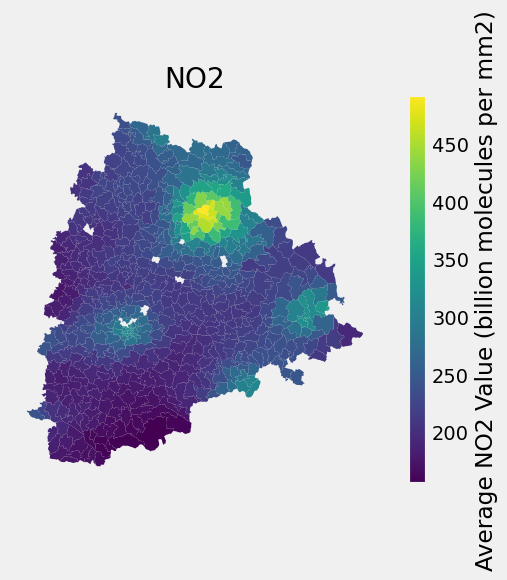

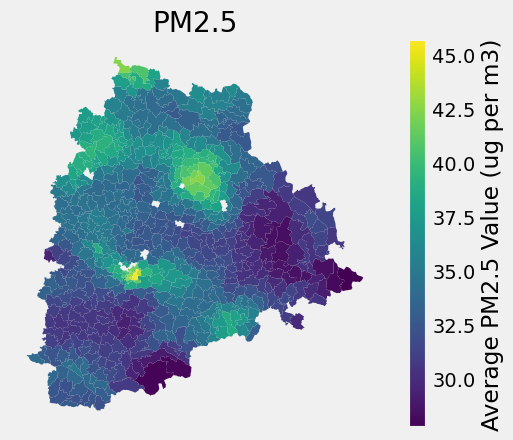

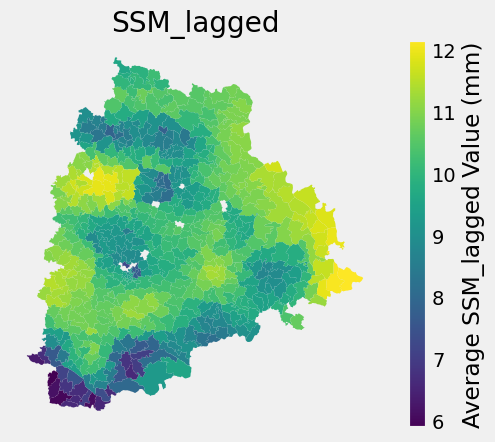

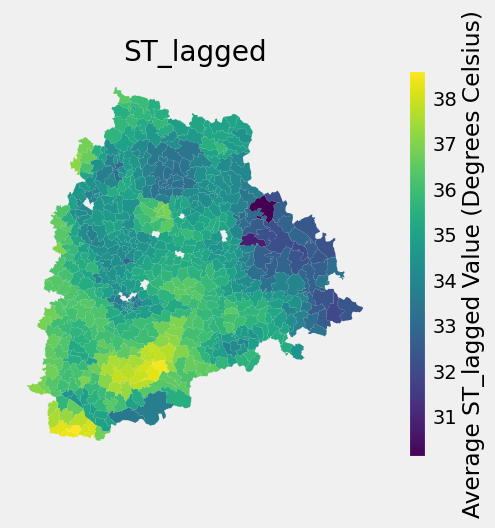

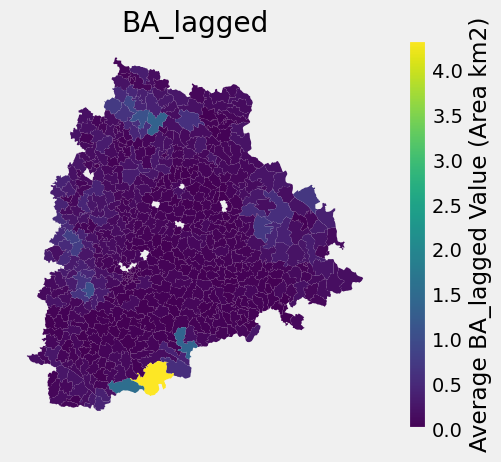

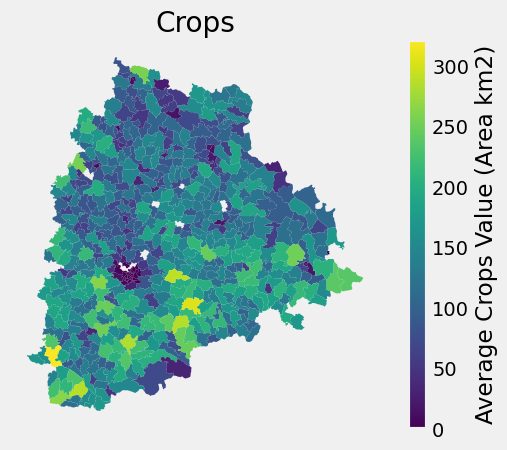

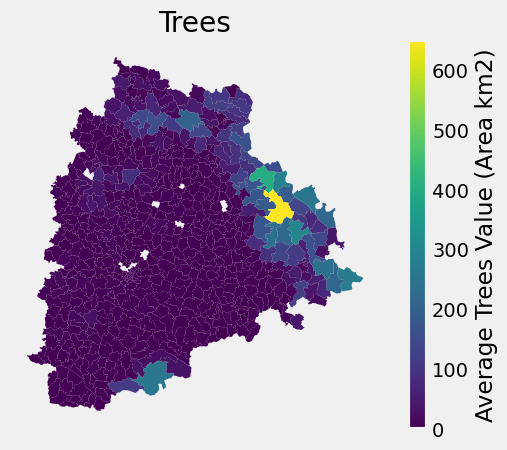

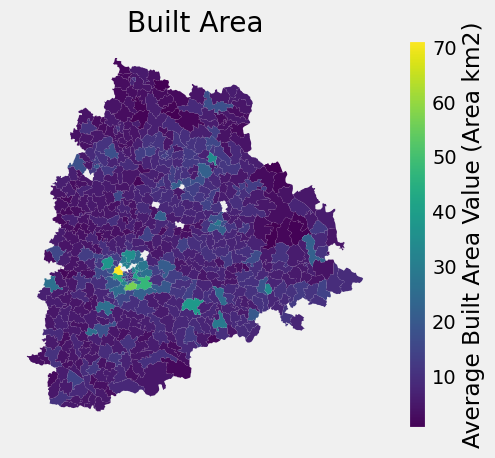

In [67]:
for parameter in range(0, len(parameters)):
        
    df_geo = data_all.groupby('index')[parameters[parameter]].mean().reset_index()
    df_geo = pd.merge(df_geo, mandal_boundaries[['index', 'geometry']], on=['index'])
    df_geo = gpd.GeoDataFrame(df_geo, geometry = df_geo.geometry, crs = {'init': 'epsg:4326'}) 


    df_geo.plot(column=parameters[parameter], legend=True, legend_kwds = {'label': 'Average ' + parameters[parameter] + ' Value ' + units[parameter]})
    plt.axis('off')
    plt.title(parameters[parameter])
    plt.show()